In [1]:
import numpy as np
from scipy.stats import multivariate_normal # 多次元ガウス分布
from scipy.special import psi # ディガンマ関数
import matplotlib.pyplot as plt

In [2]:
# 次元数を設定:(固定)
D = 2

# クラスタ数を指定
K = 3

# K個の真の平均を指定
mu_truth_kd = np.array(
    [[5.0, 35.0], 
     [-20.0, -10.0], 
     [30.0, -20.0]]
)

# K個の真の分散共分散行列を指定
sigma2_truth_kdd = np.array(
    [[[250.0, 65.0], [65.0, 270.0]], 
     [[125.0, -45.0], [-45.0, 175.0]], 
     [[210.0, -15.0], [-15.0, 250.0]]]
)

In [3]:
# 確認
print(mu_truth_kd)
print(sigma2_truth_kdd)

[[  5.  35.]
 [-20. -10.]
 [ 30. -20.]]
[[[250.  65.]
  [ 65. 270.]]

 [[125. -45.]
  [-45. 175.]]

 [[210. -15.]
  [-15. 250.]]]


In [4]:
# 真の混合比率を指定
pi_truth_k = np.array([0.45, 0.25, 0.3])

In [5]:
# 作図用のx軸のxの値を作成
x_1_line = np.linspace(
    np.min(mu_truth_kd[:, 0] - 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])), 
    np.max(mu_truth_kd[:, 0] + 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])), 
    num=300
)

# 作図用のy軸のxの値を作成
x_2_line = np.linspace(
    np.min(mu_truth_kd[:, 1] - 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])), 
    np.max(mu_truth_kd[:, 1] + 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])), 
    num=300
)

# 作図用の格子状の点を作成
x_1_grid, x_2_grid = np.meshgrid(x_1_line, x_2_line)

# 作図用のxの点を作成
x_point = np.stack([x_1_grid.flatten(), x_2_grid.flatten()], axis=1)

# 作図用に各次元の要素数を保存
x_dim = x_1_grid.shape
print(x_dim)

(300, 300)


In [6]:
print(x_point[:5])

[[-53.54101966 -67.4341649 ]
 [-53.11621983 -67.4341649 ]
 [-52.69142    -67.4341649 ]
 [-52.26662017 -67.4341649 ]
 [-51.84182033 -67.4341649 ]]


In [7]:
# 観測モデルを計算
true_model = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(
        x=x_point, mean=mu_truth_kd[k], cov=sigma2_truth_kdd[k]
    )
    
    # K個の分布の加重平均を計算
    true_model += pi_truth_k[k] * tmp_density

In [8]:
print(true_model[:5])

[9.06768334e-13 1.07345258e-12 1.27033352e-12 1.50260830e-12
 1.77630256e-12]


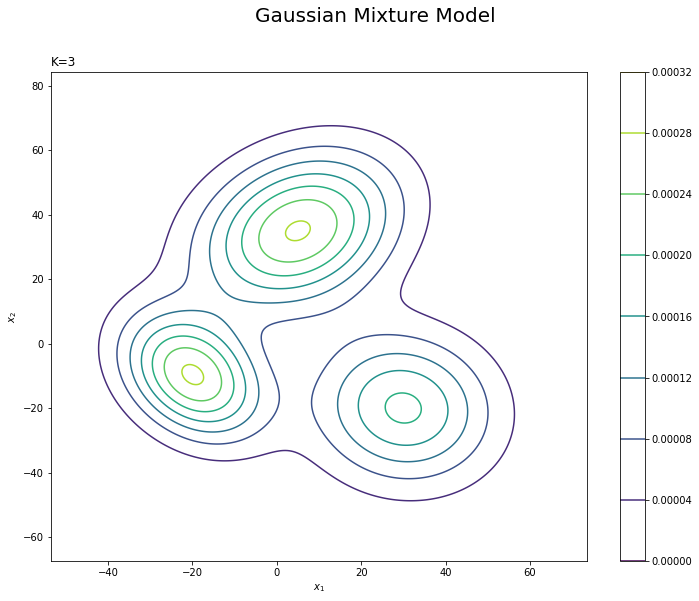

In [9]:
# 観測モデルを作図
plt.figure(figsize=(12, 9))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim)) # 真の分布
plt.suptitle('Gaussian Mixture Model', fontsize=20)
plt.title('K=' + str(K), loc='left')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar()
plt.show()

In [10]:
# (観測)データ数を指定
N = 250

# 潜在変数を生成
s_truth_nk = np.random.multinomial(n=1, pvals=pi_truth_k, size=N)

In [11]:
print(s_truth_nk[:5])

[[1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]]


In [12]:
# クラスタ番号を抽出
_, s_truth_n = np.where(s_truth_nk == 1)

# 確認
print(s_truth_n[:5])

[0 2 2 1 0]


In [13]:
# (観測)データを生成
x_nd = np.array([
    np.random.multivariate_normal(
        mean=mu_truth_kd[k], cov=sigma2_truth_kdd[k], size=1
    ).flatten() for k in s_truth_n
])

In [14]:
# 確認
print(x_nd[:5])

[[  7.23285003  24.63630609]
 [ 21.63121996 -24.21811863]
 [ 61.94968348 -30.71479531]
 [-36.3897137    4.59151602]
 [ -4.44955741  34.01187339]]


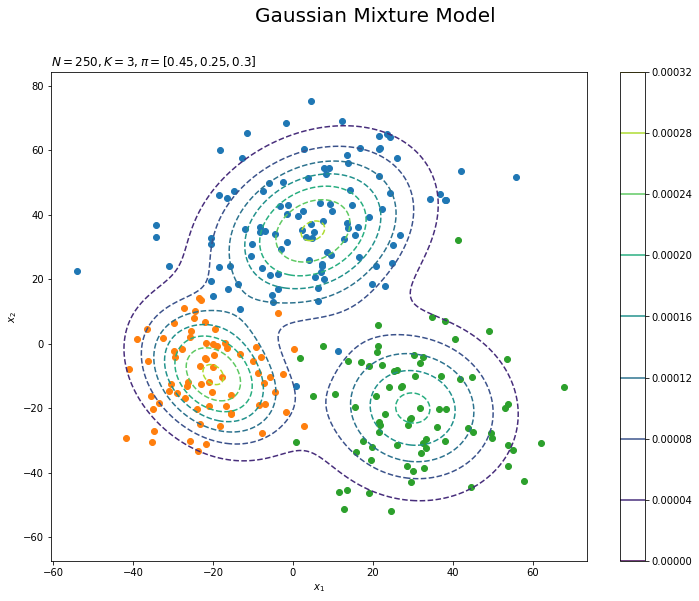

In [15]:
# 観測データの散布図を作成
plt.figure(figsize=(12, 9))
for k in range(K):
    k_idx, = np.where(s_truth_n == k) # クラスタkのデータのインデック
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1)) # 観測データ
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), linestyles='--') # 真の分布
plt.suptitle('Gaussian Mixture Model', fontsize=20)
plt.title('$N=' + str(N) + ', K=' + str(K) + 
          ', \pi=[' + ', '.join([str(pi) for pi in pi_truth_k]) + ']$', loc='left')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar()
plt.show()

In [16]:
# muの事前分布のパラメータを指定
beta = 1.0
m_d = np.repeat(0.0, D)

# lambdaの事前分布のパラメータを指定
w_dd = np.identity(D) * 0.0005
nu = D

# piの事前分布のパラメータを指定
alpha_k = np.repeat(2.0, K)

In [17]:
# muの事前分布の標準偏差を計算
sigma_mu_d = np.sqrt(
    np.linalg.inv(beta * nu * w_dd).diagonal()
)

# 作図用のx軸のmuの値を作成
mu_0_line = np.linspace(
    np.min(mu_truth_kd[:, 0]) - sigma_mu_d[0], 
    np.max(mu_truth_kd[:, 0]) + sigma_mu_d[0], 
    num=300
)

# 作図用のy軸のmuの値を作成
mu_1_line = np.linspace(
    np.min(mu_truth_kd[:, 1]) - sigma_mu_d[1], 
    np.max(mu_truth_kd[:, 1]) + sigma_mu_d[1], 
    num=300
)

# 作図用の格子状の点を作成
mu_0_grid, mu_1_grid = np.meshgrid(mu_0_line, mu_1_line)

# 作図用のmuの点を作成
mu_point = np.stack([mu_0_grid.flatten(), mu_1_grid.flatten()], axis=1)

# 作図用に各次元の要素数を保存
mu_dim = mu_0_grid.shape
print(mu_dim)

(300, 300)


In [18]:
# muの事前分布を計算
prior_mu_density = multivariate_normal.pdf(
    x=mu_point, mean=m_d, cov=np.linalg.inv(beta * nu * w_dd)
)

In [19]:
# 確認
print(prior_mu_density[:5])

[1.10780663e-05 1.12959859e-05 1.15165400e-05 1.17397162e-05
 1.19655008e-05]


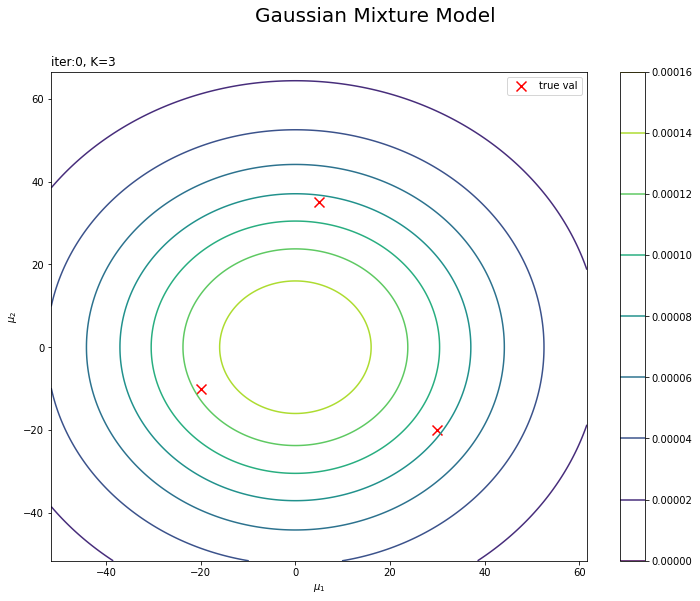

In [20]:
# muの事前分布を作図
plt.figure(figsize=(12, 9))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='true val', 
            color='red', s=100, marker='x') # 真の平均
plt.contour(mu_0_grid, mu_1_grid, prior_mu_density.reshape(mu_dim)) # 事前分布
plt.suptitle('Gaussian Mixture Model', fontsize=20)
plt.title('iter:' + str(0) + ', K=' + str(K), loc='left')
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.colorbar()
plt.legend()
plt.show()

In [21]:
# 潜在変数の近似事後分布の期待値を初期化
E_s_nk = np.random.uniform(low=0.0, high=1.0, size=(N, K))
E_s_nk /= np.sum(E_s_nk, axis=1, keepdims=True)

In [22]:
# 確認
print(E_s_nk[:5])
print(np.sum(E_s_nk[:5], axis=1))

[[0.20488691 0.43161701 0.36349608]
 [0.63345613 0.02651109 0.34003279]
 [0.0274973  0.47566447 0.49683822]
 [0.37956652 0.08124311 0.53919037]
 [0.46449315 0.41148531 0.12402155]]
[1. 1. 1. 1. 1.]


In [23]:
# 初期値によるmuの近似事後分布のパラメータを計算:式(4.114)
beta_hat_k = np.sum(E_s_nk, axis=0) + beta
m_hat_kd = (np.dot(E_s_nk.T, x_nd) + beta * m_d) / beta_hat_k.reshape((K, 1))

In [24]:
# 確認
print(beta_hat_k)
print(m_hat_kd)

[83.56161357 83.36213212 86.07625431]
[[3.81430763 7.92443698]
 [4.32385234 7.17751456]
 [6.57492083 4.49920865]]


In [25]:
# 初期値によるlambdaの近似後分布のパラメータを計算:式(4.118)
w_hat_kdd = np.zeros((K, D, D))
for k in range(K):
    inv_w_dd = np.dot(E_s_nk[:, k] * x_nd.T, x_nd)
    inv_w_dd += beta * np.dot(m_d.reshape((D, 1)), m_d.reshape((1, D)))
    inv_w_dd -= beta_hat_k[k] * np.dot(m_hat_kd[k].reshape((D, 1)), m_hat_kd[k].reshape((1, D)))
    inv_w_dd += np.linalg.inv(w_dd)
    w_hat_kdd[k] = np.linalg.inv(inv_w_dd)
nu_hat_k = np.sum(E_s_nk, axis=0) + nu

In [26]:
# 確認
print(w_hat_kdd)
print(nu_hat_k)

[[[2.02214490e-05 1.15511229e-06]
  [1.15511229e-06 1.22018648e-05]]

 [[1.86729072e-05 1.09552228e-06]
  [1.09552228e-06 1.34362555e-05]]

 [[1.80547885e-05 1.73127212e-06]
  [1.73127212e-06 1.31811219e-05]]]
[84.56161357 84.36213212 87.07625431]


In [27]:
# 確認
print(w_hat_kdd)
print(nu_hat_k)

[[[2.02214490e-05 1.15511229e-06]
  [1.15511229e-06 1.22018648e-05]]

 [[1.86729072e-05 1.09552228e-06]
  [1.09552228e-06 1.34362555e-05]]

 [[1.80547885e-05 1.73127212e-06]
  [1.73127212e-06 1.31811219e-05]]]
[84.56161357 84.36213212 87.07625431]


In [28]:
# 初期値によるpiの近似事後分布のパラメータを計算:式(4.58)
alpha_hat_k = np.sum(E_s_nk, axis=0) + alpha_k


In [29]:
# 確認
print(alpha_hat_k)

[84.56161357 84.36213212 87.07625431]


In [30]:
# 初期値によるmuの近似事後分布を計算
posterior_density_kg = np.empty((K, mu_point.shape[0]))
for k in range(K):
    # クラスタkのmuの近似事後分布を計算
    posterior_density_kg[k] = multivariate_normal.pdf(
        x=mu_point, 
        mean=m_hat_kd[k], 
        cov=np.linalg.inv(beta_hat_k[k] * nu_hat_k[k] * w_hat_kdd[k])
    )

In [31]:
# 確認
print(posterior_density_kg[:, :5])

[[6.32798404e-176 1.51254699e-174 3.54201668e-173 8.12625701e-172
  1.82653808e-170]
 [1.10454187e-173 2.09932505e-172 3.91557977e-171 7.16690007e-170
  1.28731700e-168]
 [5.73048796e-188 1.47638576e-186 3.73058950e-185 9.24537340e-184
  2.24719533e-182]]


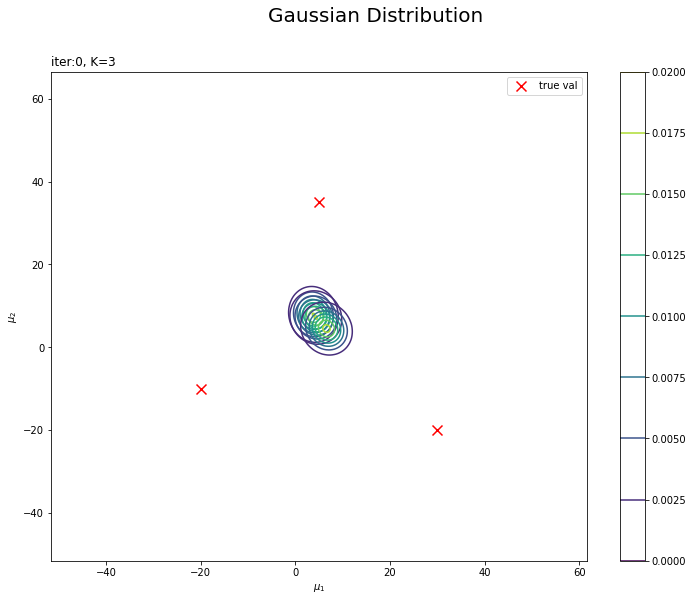

In [32]:
# 初期値によるmuの近似事後分布を作図
plt.figure(figsize=(12, 9))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='true val', 
            color='red', s=100, marker='x') # 真の平均
for k in range(K):
    plt.contour(mu_0_grid, mu_1_grid, posterior_density_kg[k].reshape(mu_dim)) # 近似事後分布
plt.suptitle('Gaussian Distribution', fontsize=20)
plt.title('iter:' + str(0) + ', K=' + str(K), loc='left')
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.colorbar()
plt.legend()
plt.show()

In [33]:
# 初期値による混合分布を計算
init_density = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(
        x=x_point, mean=m_hat_kd[k], cov=np.linalg.inv(nu_hat_k[k] * w_hat_kdd[k])
    )
    
    # K個の分布の加重平均を計算
    init_density += alpha_hat_k[k] / np.sum(alpha_hat_k) * tmp_density

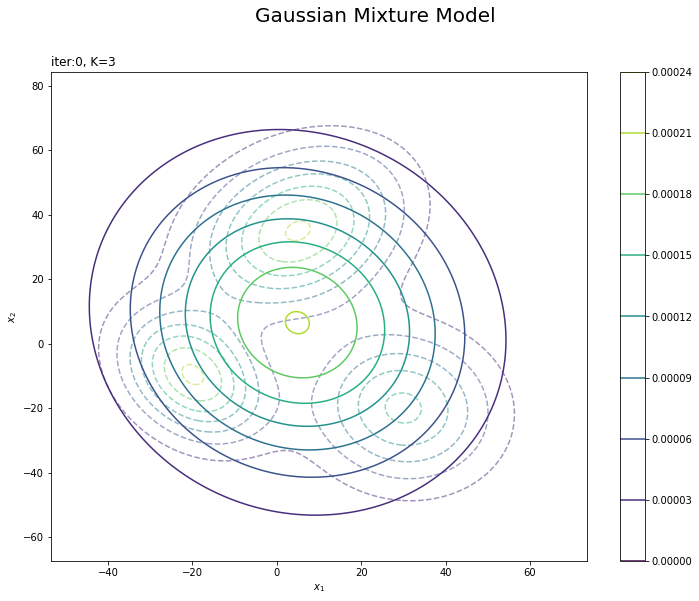

In [34]:
# 初期値による分布を作図
plt.figure(figsize=(12, 9))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), 
            alpha=0.5, linestyles='dashed') # 真の分布
plt.contour(x_1_grid, x_2_grid, init_density.reshape(x_dim)) # 期待値による分布:(等高線)
plt.suptitle('Gaussian Mixture Model', fontsize=20)
plt.title('iter:' + str(0) + ', K=' + str(K), loc='left')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar()
plt.show()


In [35]:
# 確率が最大のクラスタ番号を抽出
s_n = np.argmax(E_s_nk, axis=1)

# 各データのクラスタとなる確率を抽出
prob_s_n = E_s_nk[np.arange(N), s_n]

# 確認
print(s_n[:5])
print(prob_s_n[:5])

[1 0 2 2 0]
[0.43161701 0.63345613 0.49683822 0.53919037 0.46449315]


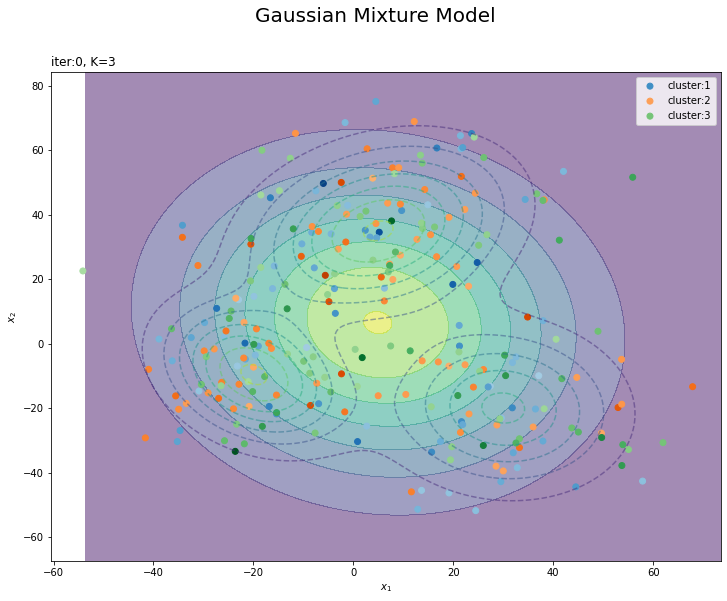

In [36]:
# K個のカラーマップを指定
colormap_list = ['Blues', 'Oranges', 'Greens']

# クラスタの散布図を作成
plt.figure(figsize=(12, 9))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), 
            alpha=0.5, linestyles='dashed') # 真の分布
plt.contourf(x_1_grid, x_2_grid, init_density.reshape(x_dim), alpha=0.5) # 期待値による分布:(塗りつぶし)
for k in range(K):
    k_idx, = np.where(s_n == k) # クラスタkのデータのインデックス
    cm = plt.get_cmap(colormap_list[k]) # クラスタkのカラーマップを設定
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1), 
                c=[cm(p) for p in prob_s_n[k_idx]]) # 確率によるクラスタ
plt.suptitle('Gaussian Mixture Model', fontsize=20)
plt.title('iter:' + str(0)+ ', K=' + str(K), loc='left')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()


In [37]:
# 試行回数を指定
MaxIter = 100

# 途中計算に用いる項の受け皿を作成
ln_eta_nk = np.zeros((N, K))

# 推移の確認用の受け皿
trace_E_s_ink = [E_s_nk.copy()]
trace_beta_ik = [beta_hat_k.copy()]
trace_m_ikd = [m_hat_kd.copy()]
trace_w_ikdd = [w_hat_kdd.copy()]
trace_nu_ik = [nu_hat_k.copy()]
trace_alpha_ik = [alpha_hat_k.copy()]

# 変分推論
for i in range(MaxIter):
    
    # 潜在変数の近似事後分布のパラメータを計算:式(4.109)
    for k in range(K):
        # クラスタkの中間変数を計算:式(4.119-4.122,4.62)
        E_lmd_dd = nu_hat_k[k] * w_hat_kdd[k]
        E_ln_det_lmd = np.sum(psi(0.5 * (nu_hat_k[k] - np.arange(D))))
        E_ln_det_lmd += D * np.log(2) + np.log(np.linalg.det(w_hat_kdd[k]))
        E_lmd_mu_d1 = np.dot(E_lmd_dd, m_hat_kd[k].reshape((D, 1)))
        E_mu_lmd_mu = np.dot(m_hat_kd[k].reshape((1, D)), E_lmd_mu_d1).item()
        E_mu_lmd_mu += D / beta_hat_k[k]
        E_ln_pi = psi(alpha_hat_k[k]) - psi(np.sum(alpha_hat_k))
        ln_eta_nk[:, k] = - 0.5 * np.diag(x_nd.dot(E_lmd_dd).dot(x_nd.T))
        ln_eta_nk[:, k] += np.dot(x_nd, E_lmd_mu_d1).flatten()
        ln_eta_nk[:, k] += - 0.5 * E_mu_lmd_mu + 0.5 * E_ln_det_lmd + E_ln_pi
    tmp_eta_nk = np.exp(ln_eta_nk)
    eta_nk = (tmp_eta_nk + 1e-7) / np.sum(tmp_eta_nk + 1e-7, axis=1, keepdims=True) # 正規化
    
    # 潜在変数の近似事後分布の期待値を計算:式(4.59)
    E_s_nk = eta_nk.copy()
    
    # muの近似事後分布のパラメータを計算:式(4.114)
    beta_hat_k = np.sum(E_s_nk, axis=0) + beta
    m_hat_kd = (np.dot(E_s_nk.T, x_nd) + beta * m_d) / beta_hat_k.reshape((K, 1))
    
    # lambdaの近似事後分布のパラメータを計算:式(4.118)
    w_hat_kdd = np.zeros((K, D, D))
    for k in range(K):
        inv_w_dd = np.dot(E_s_nk[:, k] * x_nd.T, x_nd)
        inv_w_dd += beta * np.dot(m_d.reshape((D, 1)), m_d.reshape((1, D)))
        inv_w_dd -= beta_hat_k[k] * np.dot(m_hat_kd[k].reshape((D, 1)), m_hat_kd[k].reshape((1, D)))
        inv_w_dd += np.linalg.inv(w_dd)
        w_hat_kdd[k] = np.linalg.inv(inv_w_dd)
    nu_hat_k = np.sum(E_s_nk, axis=0) + nu
        
    # piの近似事後分布のパラメータを計算:式(4.58)
    alpha_hat_k = np.sum(E_s_nk, axis=0) + alpha_k
    
    # i回目のパラメータを記録
    trace_E_s_ink.append(E_s_nk.copy())
    trace_beta_ik.append(beta_hat_k.copy())
    trace_m_ikd.append(m_hat_kd.copy())
    trace_w_ikdd.append(w_hat_kdd.copy())
    trace_nu_ik.append(nu_hat_k.copy())
    trace_alpha_ik.append(alpha_hat_k.copy())
    
    # 動作確認
    #print(str(i + 1) + ' (' + str(np.round((i + 1) / MaxIter * 100, 1)) + '%)')

In [38]:
# muの近似事後分布を計算
posterior_density_kg = np.empty((K, mu_point.shape[0]))
for k in range(K):
    # クラスタkのmuの近似事後分布を計算
    posterior_density_kg[k] = multivariate_normal.pdf(
        x=mu_point, 
        mean=m_hat_kd[k], 
        cov=np.linalg.inv(beta_hat_k[k] * nu_hat_k[k] * w_hat_kdd[k])
    )

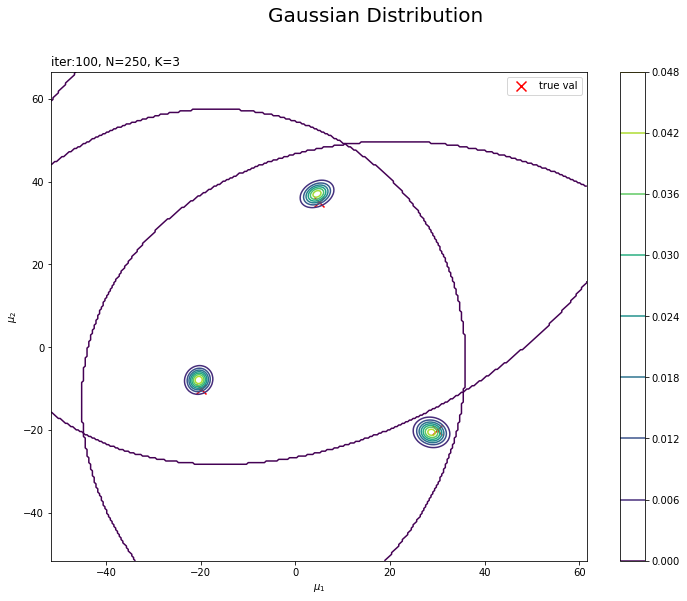

In [39]:
# muの近似事後分布を作図
plt.figure(figsize=(12, 9))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='true val', 
            color='red', s=100, marker='x') # 真の平均
for k in range(K):
    plt.contour(mu_0_grid, mu_1_grid, posterior_density_kg[k].reshape(mu_dim)) # 事後分布
plt.suptitle('Gaussian Distribution', fontsize=20)
plt.title('iter:' + str(MaxIter) + ', N=' + str(N) + ', K=' + str(K), loc='left')
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.colorbar()
plt.legend()
plt.show()

In [40]:
# K個のカラーマップを指定
colormap_list = ['Blues', 'Oranges', 'Greens']

# 確率が最大のクラスタ番号を抽出
s_n = np.argmax(E_s_nk, axis=1)

# 各データのクラスタとなる確率を抽出
prob_s_n = E_s_nk[np.arange(N), s_n]

# 最後に更新したパラメータの期待値による混合分布を計算
res_density = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(
        x=x_point, mean=m_hat_kd[k], cov=np.linalg.inv(nu_hat_k[k] * w_hat_kdd[k])
    )
    
    # K個の分布の加重平均を計算
    res_density += alpha_hat_k[k] / np.sum(alpha_hat_k) * tmp_density

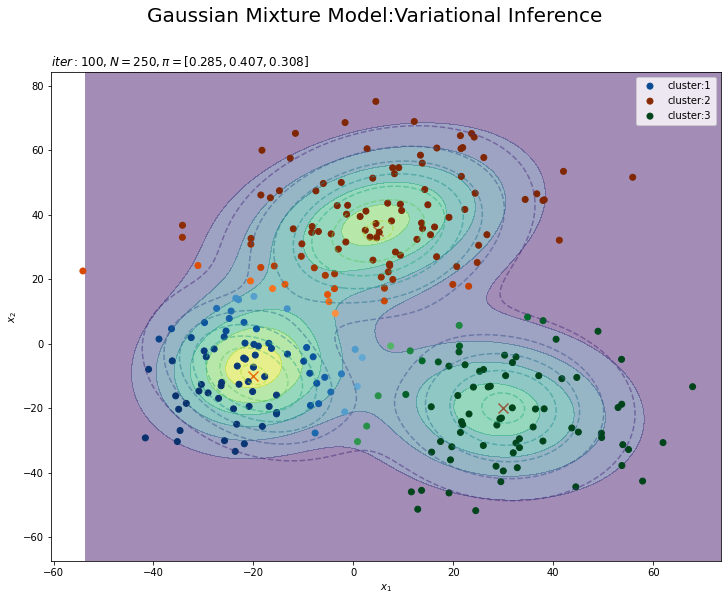

In [41]:
# 最後に更新したパラメータの期待値による分布を作図
plt.figure(figsize=(12, 9))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), 
            alpha=0.5, linestyles='dashed') # 真の分布
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], 
            color='red', s=100, marker='x') # 真の平均
plt.contourf(x_1_grid, x_2_grid, res_density.reshape(x_dim), alpha=0.5) # 期待値による分布:(塗りつぶし)
for k in range(K):
    k_idx, = np.where(s_n == k) # クラスタkのデータのインデックス
    cm = plt.get_cmap(colormap_list[k]) # クラスタkのカラーマップを設定
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1), 
                c=[cm(p) for p in prob_s_n[k_idx]]) # 確率によるクラスタ
#plt.contour(x_1_grid, x_2_grid, res_density.reshape(x_dim)) # 期待値による分布:(等高線)
#plt.colorbar() # 等高線の値:(等高線用)
plt.suptitle('Gaussian Mixture Model:Variational Inference', fontsize=20)
plt.title('$iter:' + str(MaxIter) + ', N=' + str(N) + 
          ', \pi=[' + ', '.join([str(pi) for pi in np.round(alpha_hat_k / np.sum(alpha_hat_k), 3)]) + ']$', 
          loc='left')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

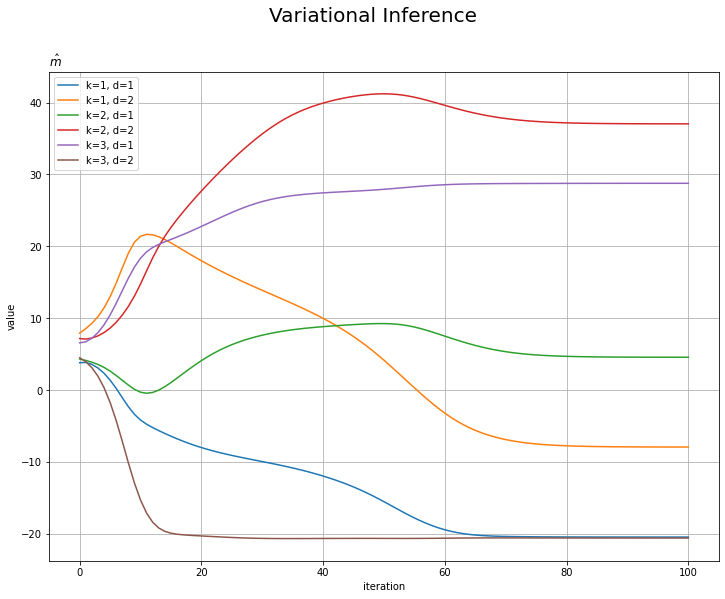

In [42]:
# mの推移を作図
plt.figure(figsize=(12, 9))
for k in range(K):
    for d in range(D):
        plt.plot(np.arange(MaxIter+1), np.array(trace_m_ikd)[:, k, d], 
                 label='k=' + str(k + 1) + ', d=' + str(d + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.suptitle('Variational Inference', fontsize=20)
plt.title('$\hat{m}$', loc='left')
plt.legend() # 凡例
plt.grid() # グリッド線
plt.show()

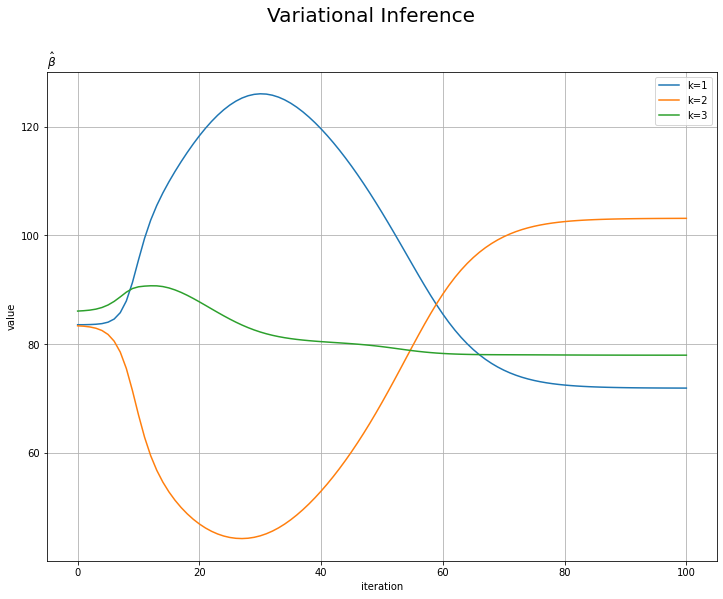

In [43]:
# betaの推移を作図
plt.figure(figsize=(12, 9))
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_beta_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.suptitle('Variational Inference', fontsize=20)
plt.title('$\hat{\\beta}$', loc='left')
plt.legend() # 凡例
plt.grid() # グリッド線
plt.show()

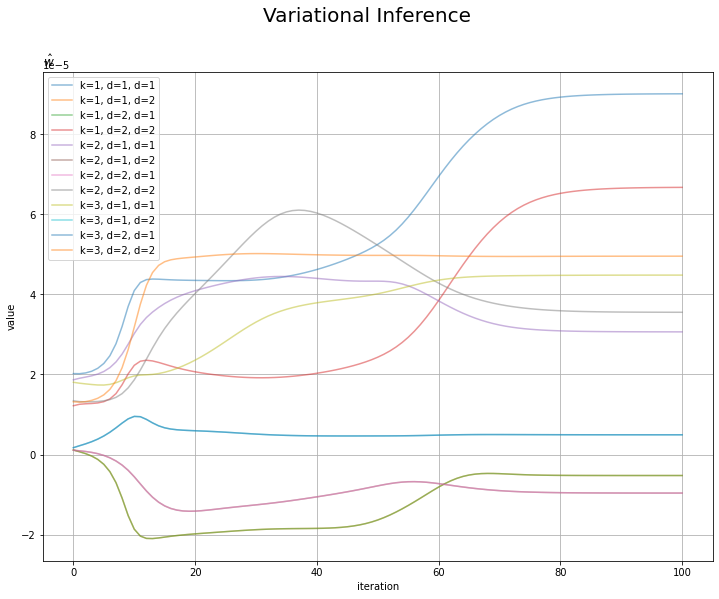

In [44]:
# wの推移を作図
plt.figure(figsize=(12, 9))
for k in range(K):
    for d1 in range(D):
        for d2 in range(D):
            plt.plot(np.arange(MaxIter + 1), np.array(trace_w_ikdd)[:, k, d1, d2], 
                     alpha=0.5, label='k=' + str(k + 1) + ', d=' + str(d1 + 1) + ', d''=' + str(d2 + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.suptitle('Variational Inference', fontsize=20)
plt.title('$\hat{w}$', loc='left')
plt.legend() # 凡例
plt.grid() # グリッド線
plt.show()

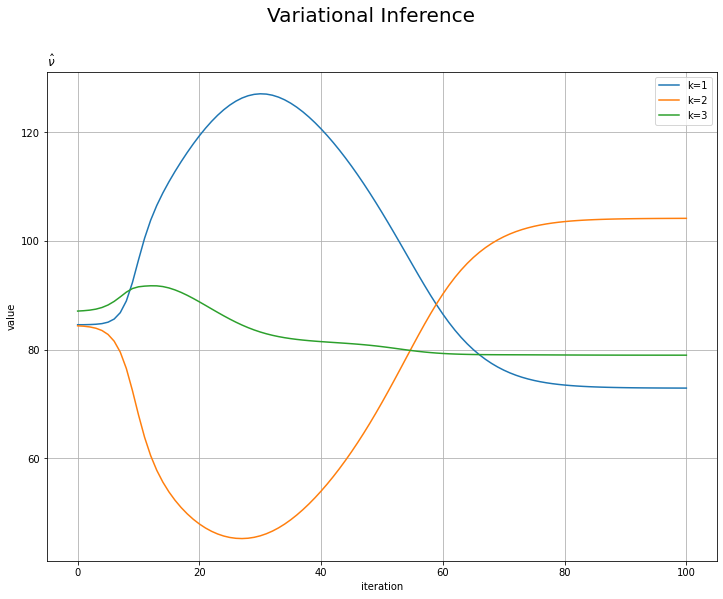

In [45]:
# nuの推移を作図
plt.figure(figsize=(12, 9))
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_nu_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.suptitle('Variational Inference', fontsize=20)
plt.title('$\hat{\\nu}$', loc='left')
plt.legend() # 凡例
plt.grid() # グリッド線
plt.show()

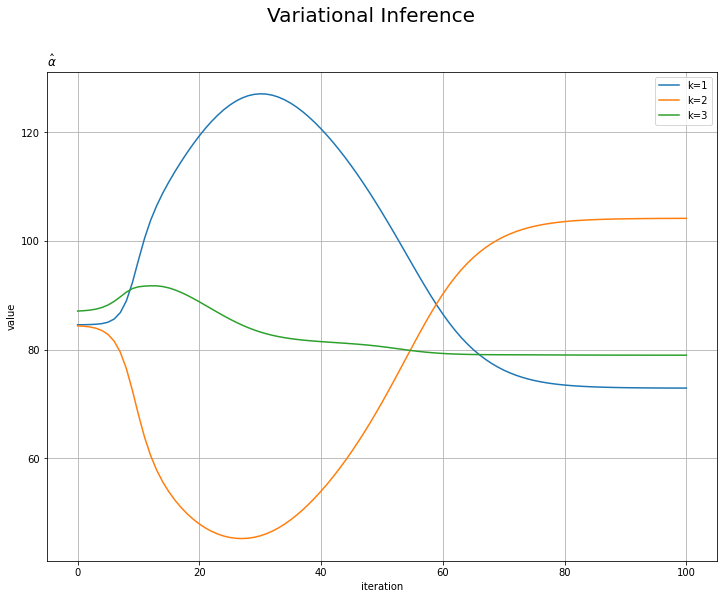

In [46]:
# alphaの推移を作図
plt.figure(figsize=(12, 9))
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_alpha_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.suptitle('Variational Inference', fontsize=20)
plt.title('$\hat{\\alpha}$', loc='left')
plt.legend() # 凡例
plt.grid() # グリッド線
plt.show()

In [51]:
# 追加ライブラリ
import matplotlib.animation as animation